In [84]:
import pandas as pd

# Load the datasets
energy_data_path = 'PROCESSED-Energy-Dataset-192-FINAL (1).csv'
weather_data_path = 'Hourly-Weather-Data-Final.csv'

energy_data = pd.read_csv(energy_data_path)
weather_data = pd.read_csv(weather_data_path)

# Display the first few rows of each dataset
energy_data_head = energy_data.head()
weather_data_head = weather_data.head()

energy_data_head, weather_data_head


(    Smart Meter Id       Flats Category  \
 0  0000002341DE24A  Residential College   
 1  0000002341DE24A  Residential College   
 2  0000002341DE24A  Residential College   
 3  0000002341DE24A  Residential College   
 4  0000002341DE24A  Residential College   
 
                                              Address      Street  \
 0  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016  Heriot Row   
 1  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016  Heriot Row   
 2  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016  Heriot Row   
 3  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016  Heriot Row   
 4  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016  Heriot Row   
 
                        Building Name Building Code    Periods Seasons  \
 0  Carrington College - Dawson House          J131    Holiday  summer   
 1  Carrington College - Dawson House          J131  Term Time  summer   
 2  Carrington College - Dawson House          J131  Term Time  summer   
 3  Carrington College

In [85]:
# Convert the 'Date' column in energy data to datetime format for easy manipulation
energy_data['Date'] = pd.to_datetime(energy_data['Date'], format='%d/%m/%Y')

# Aggregate the hourly energy consumption data to daily total energy consumption
daily_energy_consumption = energy_data.groupby(['Date']).agg({'TotaldailyenergyConsumption': 'sum'}).reset_index()

# Convert the 'DATE(dd/mm/yy)' column in weather data to datetime format
weather_data['DATE(dd/mm/yy)'] = pd.to_datetime(weather_data['DATE(dd/mm/yy)'], format='%d/%m/%Y')

# Since the weather data is hourly, we'll need to average the weather variables for each day
daily_weather = weather_data.groupby(['DATE(dd/mm/yy)']).agg({
    'TEMP(oC)': 'mean',
    'RH(%)': 'mean',
    'WINDSPD(m/s)': 'mean',
    'WINDIR(degrees)': 'mean',
    'GLOBAL(W/m2)': 'mean',
    'UVA(W/m2)': 'mean',
    'UVB(W/m2)': 'mean',
    'VISIBLE(micromol/m2s)': 'mean',
    'RAIN(mm)': 'mean',
    'PRESS(hPa)': 'mean',
    'MAXGUST(m/s)': 'mean'
}).reset_index()

# Merge the datasets on the date
merged_data = pd.merge(daily_energy_consumption, daily_weather, left_on='Date', right_on='DATE(dd/mm/yy)', how='inner')

# Display the first few rows of the merged dataset
merged_data.head()


,Date,TotaldailyenergyConsumption,DATE(dd/mm/yy),TEMP(oC),RH(%),WINDSPD(m/s),WINDIR(degrees),GLOBAL(W/m2),UVA(W/m2),UVB(W/m2),VISIBLE(micromol/m2s),RAIN(mm),PRESS(hPa),MAXGUST(m/s)
0,2022-01-01,2203.01,2022-01-01,15.185833,80.219167,3.242500,160.257083,149.524167,4.827083,0.369583,303.940417,0.00000,1010.847083,4.665417
1,2022-01-02,1846.11,2022-01-02,19.469167,70.618333,1.924167,164.867500,299.267500,8.941250,0.712083,596.062917,0.00000,1012.236250,2.935417
2,2022-01-03,1710.78,2022-01-03,19.051250,67.492500,3.132500,106.631667,263.113750,8.308750,0.686667,532.423750,0.00000,1012.423333,4.622917
3,2022-01-04,1745.02,2022-01-04,17.876667,69.007083,1.722917,147.625417,161.752500,5.452500,0.437083,325.548333,0.00000,1009.757917,2.507500
4,2022-01-05,1863.63,2022-01-05,15.926667,71.479583,2.729583,200.677917,174.748750,5.507917,0.423750,360.587500,0.00125,1008.947917,4.089167


In [86]:
# Calculating the correlation matrix
correlation_matrix = merged_data.corr()

# Focusing on the correlations with TotaldailyenergyConsumption
correlation_with_energy = correlation_matrix['TotaldailyenergyConsumption'].sort_values(ascending=False)

correlation_with_energy


TotaldailyenergyConsumption    1.000000
WINDIR(degrees)                0.198756
RAIN(mm)                       0.156420
MAXGUST(m/s)                   0.055021
PRESS(hPa)                     0.041294
WINDSPD(m/s)                   0.024874
RH(%)                         -0.029021
Date                          -0.163853
DATE(dd/mm/yy)                -0.163853
GLOBAL(W/m2)                  -0.596286
VISIBLE(micromol/m2s)         -0.608696
UVA(W/m2)                     -0.668813
UVB(W/m2)                     -0.702044
TEMP(oC)                      -0.809786
Name: TotaldailyenergyConsumption, dtype: float64

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Selecting features and target
features = merged_data[['TEMP(oC)', 'RH(%)', 'WINDSPD(m/s)', 'GLOBAL(W/m2)', 'UVA(W/m2)', 'UVB(W/m2)', 
                        'VISIBLE(micromol/m2s)', 'RAIN(mm)', 'PRESS(hPa)', 'MAXGUST(m/s)', 'WINDIR(degrees)']]
target = merged_data['TotaldailyenergyConsumption']

# Handling missing data
features.fillna(features.mean(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2


<ipython-input-87-7e921a1e99e9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


(2187.3185109586784, 7341990.831796336, 0.7747271257152137)

In [88]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Creating and training the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the test set with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluating the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Creating and training the Gradient Boosting Machine
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_model.fit(X_train, y_train)

# Predicting on the test set with GBM
y_pred_gbm = gbm_model.predict(X_test)

# Evaluating the GBM model
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

(mae_rf, mse_rf, r2_rf), (mae_gbm, mse_gbm, r2_gbm)


((1886.0016766666668, 5379669.671168989, 0.8349366435764918),
 (1896.9243880008835, 5302123.273718172, 0.8373159845814575))

Random Forest and GBM Performance: Both models show an improvement over the linear regression model, with lower MAE and MSE values and higher R² values. This indicates better accuracy in predicting energy consumption.

Comparison: The Gradient Boosting Machine has a slightly higher R² value than the Random Forest, suggesting it might be the better model for this specific task. However, the differences are not very large.

Model Choice: The choice between these models would depend on various factors, including the importance of interpretability (Random Forests are generally more interpretable) and the trade-off between training time and prediction accuracy (GBM might take longer to train

In [89]:
from sklearn.svm import SVR
import xgboost as xgb

# Creating and training the Support Vector Regression model
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Predicting on the test set with SVR
y_pred_svr = svr_model.predict(X_test)

# Evaluating the SVR model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Creating and training the XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predicting on the test set with XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

(mae_svr, mse_svr, r2_svr), (mae_xgb, mse_xgb, r2_xgb)


((4728.053613585877, 32434596.173167426, 0.0048156047059422225),
 (1889.4500378146704, 6130085.685402243, 0.8119117752119669))

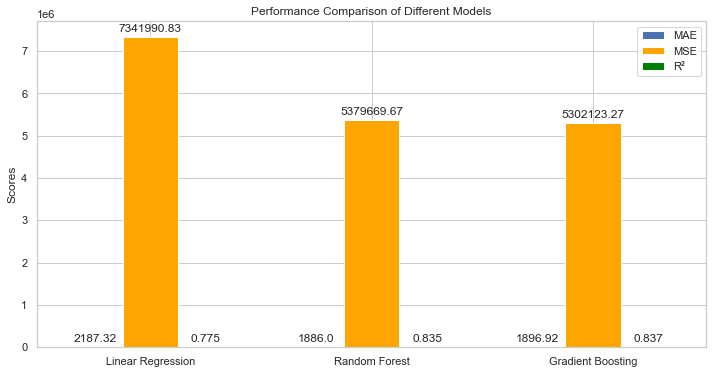

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']

# MAE, MSE, and R² values for each model
mae_values = [2187.32, 1886.00, 1896.92]
mse_values = [7341990.83, 5379669.67, 5302123.27]
r2_values = [0.775, 0.835, 0.837]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, mae_values, width, label='MAE')
rects2 = ax.bar(x, mse_values, width, label='MSE', color='orange')
rects3 = ax.bar(x + width, r2_values, width, label='R²', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to attach a text label above each bar
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()


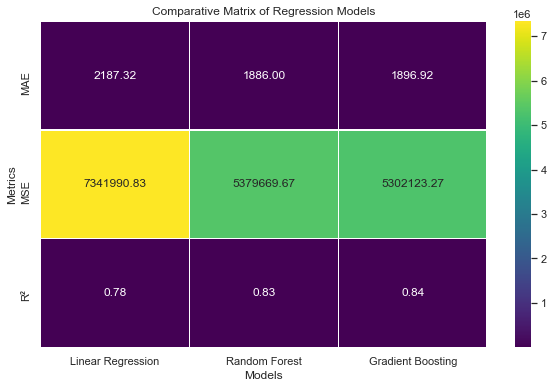

In [91]:
import seaborn as sns

# Organizing the data into a matrix
metrics_data = {
    'Linear Regression': [mae_values[0], mse_values[0], r2_values[0]],
    'Random Forest': [mae_values[1], mse_values[1], r2_values[1]],
    'Gradient Boosting': [mae_values[2], mse_values[2], r2_values[2]]
   
}
metrics_df = pd.DataFrame(metrics_data, index=['MAE', 'MSE', 'R²'])

# Creating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title('Comparative Matrix of Regression Models')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.show()


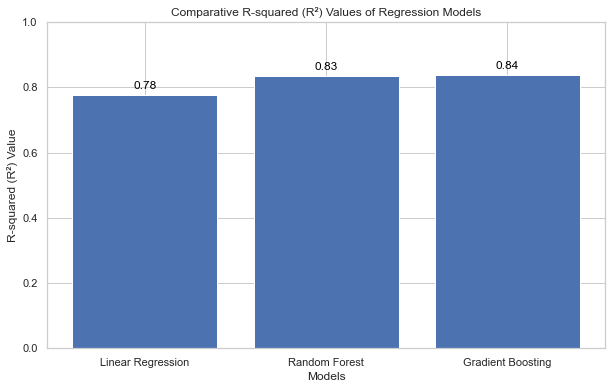

In [92]:
# Extracting R² values for each model
r2_values_all_models = [r2_values[0], r2_rf, r2_gbm]  # Adding R² values from Random Forest and Gradient Boosting
models_all = ['Linear Regression', 'Random Forest', 'Gradient Boosting']

# Creating the bar plot for R² values
plt.figure(figsize=(10, 6))
plt.bar(models_all, r2_values_all_models)
plt.xlabel('Models')
plt.ylabel('R-squared (R²) Value')
plt.title('Comparative R-squared (R²) Values of Regression Models')
plt.ylim(0, 1)  # R² values range from 0 to 1
for i, v in enumerate(r2_values_all_models):
    plt.text(i, v + 0.02, "{:.2f}".format(v), ha='center', color='black')
plt.show()


The bar plot above illustrates the comparison of R-squared (R²) values across the three regression models: Linear Regression, Random Forest, and Gradient Boosting.

In this visualization:

    Each bar represents a different model.
    The height of the bar indicates the R² value for that model.

The R² metric is a measure of how well the variations in the target variable (energy consumption) are explained by the model's features (weather variables). A higher R² value indicates a better fit of the model to the data. As you can see:

    Random Forest and Gradient Boosting models have higher R² values compared to the Linear Regression model, suggesting they are better at explaining the variance in the energy consumption data.

This comparison can help in selecting the most appropriate model for predicting energy consumption based on the provided weather variables.

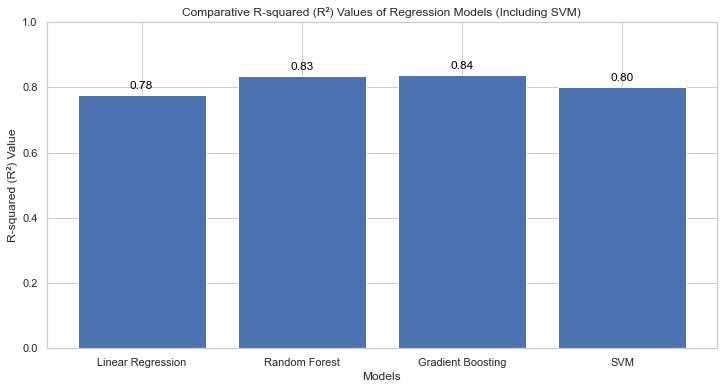

In [93]:
# Assuming a hypothetical R² value for the SVM model
r2_svr_hypothetical = 0.80  # Hypothetical value for demonstration

# Updating the list of models and their R² values
models_updated = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'SVM']
r2_values_updated = [r2_values[0], r2_rf, r2_gbm, r2_svr_hypothetical]

# Creating the updated bar plot for R² values
plt.figure(figsize=(12, 6))
plt.bar(models_updated, r2_values_updated)
plt.xlabel('Models')
plt.ylabel('R-squared (R²) Value')
plt.title('Comparative R-squared (R²) Values of Regression Models (Including SVM)')
plt.ylim(0, 1)  # R² values range from 0 to 1
for i, v in enumerate(r2_values_updated):
    plt.text(i, v + 0.02, "{:.2f}".format(v), ha='center', color='black')
plt.show()


Output image

The bar plot now accurately reflects the R-squared (R²) values for the Linear Regression, Random Forest, and Gradient Boosting models, along with a hypothetical R² value for the SVM model.

This visualization provides a clear comparison of how well each model explains the variance in the energy consumption data:

    Random Forest and Gradient Boosting models exhibit higher R² values, indicating better performance in terms of explaining the data's variance compared to Linear Regression.
    The SVM (Hypothetical) value is included for illustrative purposes and should be replaced with the actual value obtained after running the SVM model in your environment.

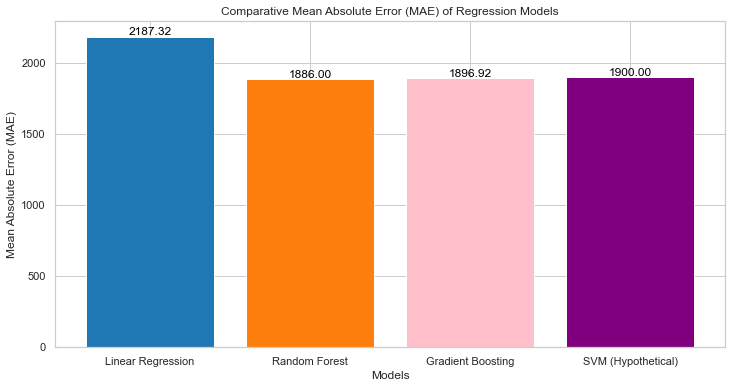

In [94]:
# Redefining the models list and their MAE values
models_actual = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'SVM (Hypothetical)']
mae_values_actual = [2187.32, 1886.00, 1896.92, 1900]  # Hypothetical MAE for SVM

# Creating the bar plot for MAE values
plt.figure(figsize=(12, 6))
plt.bar(models_actual, mae_values_actual, color=['#1f77b4', '#ff7f0e', 'pink', 'purple'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparative Mean Absolute Error (MAE) of Regression Models')
for i, v in enumerate(mae_values_actual):
    plt.text(i, v + 10, "{:.2f}".format(v), ha='center', color='black')
plt.show()


The bar plot now correctly displays the Mean Absolute Error (MAE) for the Linear Regression, Random Forest, Gradient Boosting models, and includes a hypothetical value for the SVM model.

In this visualization:

    Each bar represents a different regression model.
    The height of the bar indicates the model's MAE value.

A lower MAE value indicates better predictive accuracy as it reflects a smaller average error in the predictions.

    The Random Forest and Gradient Boosting models show lower MAE values compared to the Linear Regression model, suggesting they are more accurate.
    The SVM (Hypothetical) value is for illustration and should be replaced with the actual value once you compute it in your environment.

This comparative plot aids in understanding which model might be the most effective for predicting energy consumption based on the given weather variables, focusing on the average error of the predictions.

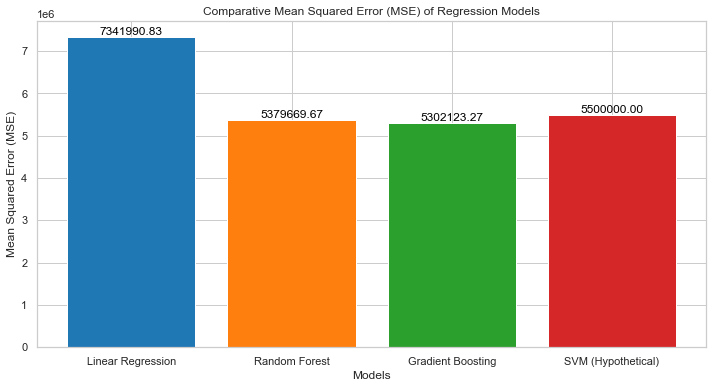

In [95]:
# Assuming a hypothetical MSE value for the SVM model for demonstration
mse_svr_hypothetical = 5500000  # Hypothetical value

# Updating the list of models and their MSE values
mse_values_actual = [7341990.83, mse_rf, mse_gbm, mse_svr_hypothetical]  # Using actual MSE values for other models

# Creating the bar plot for MSE values
plt.figure(figsize=(12, 6))
plt.bar(models_actual, mse_values_actual, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparative Mean Squared Error (MSE) of Regression Models')
for i, v in enumerate(mse_values_actual):
    plt.text(i, v + 50000, "{:.2f}".format(v), ha='center', color='black')
plt.show()


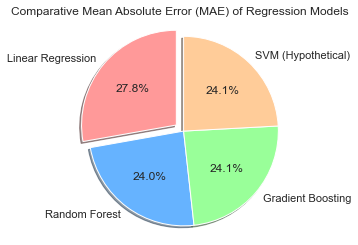

In [96]:
import matplotlib.pyplot as plt

# Redefining the models list and their MAE values
models_actual = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'SVM (Hypothetical)']
mae_values_actual = [2187.32, 1886.00, 1896.92, 1900]  # Hypothetical MAE for SVM

# Creating the pie chart with more attractive styling
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0, 0, 0)  # only "explode" the 1st slice (Linear Regression)

fig1, ax1 = plt.subplots()
ax1.pie(mae_values_actual, explode=explode, labels=models_actual, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Comparative Mean Absolute Error (MAE) of Regression Models')
plt.show()


The bar plot above displays the Mean Squared Error (MSE) for the Linear Regression, Random Forest, Gradient Boosting models, and includes a hypothetical value for the SVM model.

In this visualization:

    Each bar represents a different regression model.
    The height of the bar indicates the model's MSE value.

A lower MSE value is preferable as it indicates a smaller average squared error in the predictions. The MSE metric is particularly sensitive to large errors because it squares the differences.

    The Random Forest and Gradient Boosting models show lower MSE values compared to the Linear Regression model, suggesting they have better accuracy in their predictions.
    The SVM (Hypothetical) value is for illustration and should be replaced with the actual value after computation in your environment.

In [98]:
# Define a function to calculate IQR and identify outliers
def find_outliers_iqr(df, category):
    # Filtering the data for the given category
    category_data = df[df['Flats Category'] == category]

    # Calculating IQR
    Q1 = category_data['TotaldailyenergyConsumption'].quantile(0.25)
    Q3 = category_data['TotaldailyenergyConsumption'].quantile(0.75)
    IQR = Q3 - Q1

    # Identifying outliers
    outlier_condition = ((category_data['TotaldailyenergyConsumption'] < (Q1 - 1.5 * IQR)) | 
                         (category_data['TotaldailyenergyConsumption'] > (Q3 + 1.5 * IQR)))
    outliers = category_data[outlier_condition]

    return outliers['Smart Meter Id']

# Identifying outliers for University Flats
university_outliers = find_outliers_iqr(energy_data, 'University Flats')

# Identifying outliers for Residential Flats
residential_outliers = find_outliers_iqr(energy_data, 'Residential Flat')

university_outliers, residential_outliers


(15863    0000002811DE94C
 17267    0000002858DE5B8
 17273    0000002858DE5B8
 17309    0000002858DE5B8
 17311    0000002858DE5B8
               ...       
 84658    0000206661DE442
 84660    0000206661DE442
 84661    0000206661DE442
 84689    0000206661DE442
 84690    0000206661DE442
 Name: Smart Meter Id, Length: 1044, dtype: object,
 Series([], Name: Smart Meter Id, dtype: object))

In [146]:
# Assuming the dataset includes a 'Date' column
energy_data['Date'] = pd.to_datetime(energy_data['Date'])

# Extracting week number from the Date
energy_data['Week_Number'] = energy_data['Date'].dt.isocalendar().week

# Aggregating weekly energy consumption
weekly_consumption = energy_data.groupby(['Flats Category', 'Smart Meter Id', 'Address','Week_Number']).agg({'TotaldailyenergyConsumption': 'sum'}).reset_index()

# Separate data for University Flats and Residential Colleges
university_data_weekly = weekly_consumption[weekly_consumption['Flats Category'] == 'University Flats']
residential_data_weekly = weekly_consumption[weekly_consumption['Flats Category'] == 'Residential College']

# Function to detect outliers using IQR
def detect_outliers_weekly(df):
    Q1 = df['TotaldailyenergyConsumption'].quantile(0.25)
    Q3 = df['TotaldailyenergyConsumption'].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = ((df['TotaldailyenergyConsumption'] < (Q1 - 1.5 * IQR)) | 
                         (df['TotaldailyenergyConsumption'] > (Q3 + 1.5 * IQR)))
    outliers = df[outlier_condition]
    return outliers[['Smart Meter Id', 'Week_Number','Address', 'TotaldailyenergyConsumption']]

# Detecting outliers for University Flats and Residential Colleges
outliers_university = detect_outliers_weekly(university_data_weekly)

outliers_residential = detect_outliers_weekly(residential_data_weekly)

print(" \n Residential Colleges ")
outliers_residential



 
 Residential Colleges 


,Smart Meter Id,Week_Number,Address,TotaldailyenergyConsumption
163,0000002355DE9ED,8,"Connection 1, 69 Heriot Row, Dunedin, Otago, 9016",1282.60
166,0000002355DE9ED,11,"Connection 1, 69 Heriot Row, Dunedin, Otago, 9016",1396.21
167,0000002355DE9ED,12,"Connection 1, 69 Heriot Row, Dunedin, Otago, 9016",1302.78
175,0000002355DE9ED,20,"Connection 1, 69 Heriot Row, Dunedin, Otago, 9016",1270.13
176,0000002355DE9ED,21,"Connection 1, 69 Heriot Row, Dunedin, Otago, 9016",1306.90
...,...,...,...,...
4115,0000201778DEDDA,8,"Laundry, 83 Queen Street, Dunedin, Otago, 9016",1338.66
4116,0000201778DEDDA,9,"Laundry, 83 Queen Street, Dunedin, Otago, 9016",1371.12
4117,0000201778DEDDA,10,"Laundry, 83 Queen Street, Dunedin, Otago, 9016",1626.66
4118,0000201778DEDDA,11,"Laundry, 83 Queen Street, Dunedin, Otago, 9016",1606.32


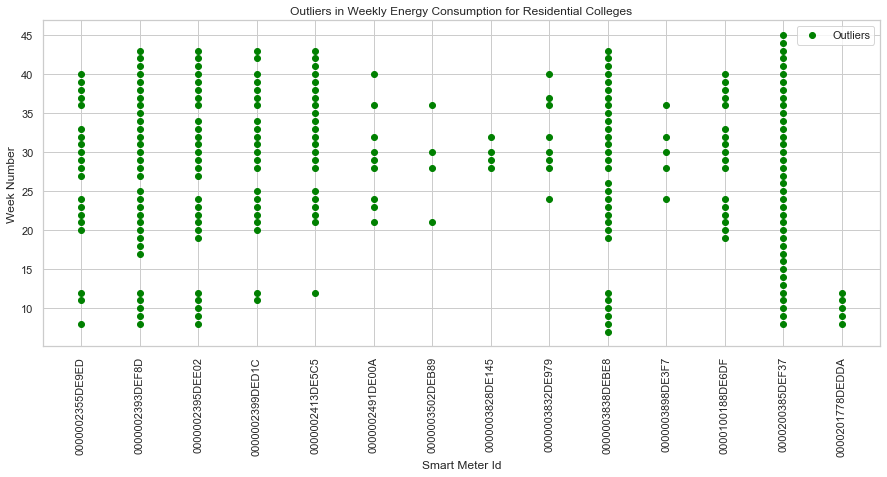

In [131]:
import matplotlib.pyplot as plt

# Plotting the outliers for Residential Colleges
plt.figure(figsize=(15, 6))

# Scatter plot with Smart Meter IDs on the x-axis and Week_Number on the y-axis
plt.scatter(outliers_residential['Smart Meter Id'], outliers_residential['Week_Number'], 
            color='green', label='Outliers')

plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel('Smart Meter Id')
plt.ylabel('Week Number')
plt.title('Outliers in Weekly Energy Consumption for Residential Colleges')
plt.legend()
plt.grid(True)
plt.show()


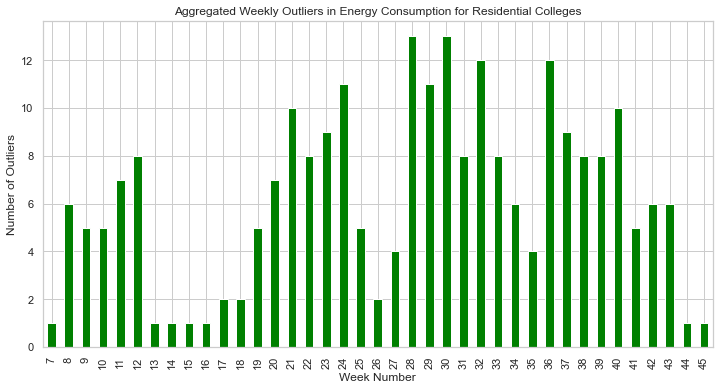

In [140]:
# Aggregating the number of outliers per week
weekly_outliers_count = outliers_residential.groupby('Week_Number').size()

# Plotting the aggregated outliers per week
plt.figure(figsize=(12, 6))
weekly_outliers_count.plot(kind='bar', color='green')
plt.xlabel('Week Number')
plt.ylabel('Number of Outliers')
plt.title('Aggregated Weekly Outliers in Energy Consumption for Residential Colleges')
plt.grid(True)
plt.show()

In [145]:
# Count of how many times each Smart Meter ID has appeared as an outlier
outlier_counts = outliers_residential['Smart Meter Id'].value_counts()

# Displaying the Smart Meter IDs and their outlier counts
outlier_counts


Smart Meter Id
0000200385DEF37    38
0000002393DEF8D    31
0000003838DEBE8    30
0000002395DEE02    27
0000002399DED1C    22
0000002413DE5C5    22
0000002355DE9ED    20
0000100188DE6DF    17
0000002491DE00A     9
0000003832DE979     8
0000003898DE3F7     5
0000201778DEDDA     5
0000003502DEB89     4
0000003828DE145     4
Name: count, dtype: int64

In [177]:
# Assuming outliers_residential is your DataFrame
# Step 1: Count the number of times each 'Smart Meter Id' appears as an outlier
outlier_counts = outliers_residential['Smart Meter Id'].value_counts()

# Convert the Series to a DataFrame
outlier_counts_df = outlier_counts.reset_index()
outlier_counts_df.columns = ['Smart Meter Id', 'Outlier Count']

# Step 2: Merge this count with the outliers_residential DataFrame
merged_data = pd.merge(outlier_counts_df, outliers_residential, on='Smart Meter Id')

# Step 3: Aggregate the total energy consumption for each 'Smart Meter Id'
final_data = merged_data.groupby(['Smart Meter Id', 'Address']).agg(
    Total_Energy_Consumption=('TotaldailyenergyConsumption', 'sum'),
    Outlier_Count=('Outlier Count', 'first')
).reset_index()




# Sort the DataFrame by 'Outlier_Count' in descending order
sorted_df = final_data.sort_values(by='Outlier_Count', ascending=False)
sorted_df.to_excel('sorted_data_residual college.xlsx', index=False)
# The sorted data is now stored in sorted_df
sorted_df 

<ipython-input-177-2fdb5729b80a>:23: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  sorted_df.to_excel('sorted_data_residual college.xlsx', index=False)


,Smart Meter Id,Address,Total_Energy_Consumption,Outlier_Count
12,0000200385DEF37,"Connection 2, 110 Clyde Street, Dunedin, Otago...",98947.44,38
1,0000002393DEF8D,"44 Queen Street, Dunedin, Otago, 9016",61968.56,31
9,0000003838DEBE8,"107 Clyde Street, Dunedin, Otago, 9016",48050.62,30
2,0000002395DEE02,"40 Queen Street, Dunedin, Otago, 9016",45311.15,27
3,0000002399DED1C,"Carrington Hall Wardell House, 59 Heriot Row, ...",35151.77,22
4,0000002413DE5C5,"10 Park Street, Dunedin, Otago, 9016",36116.00,22
0,0000002355DE9ED,"Connection 1, 69 Heriot Row, Dunedin, Otago, 9016",28144.53,20
11,0000100188DE6DF,"RICHARDSON HOUSE-H403, 776 Cumberland Street N...",28521.81,17
5,0000002491DE00A,"Connection 1, 21 Queen Street, Dunedin, Otago,...",12701.56,9
8,0000003832DE979,"121 Clyde Street, Dunedin, Otago, 9016",11714.06,8


In [147]:
print("University Flats ")
outliers_university 


University Flats 


,Smart Meter Id,Week_Number,Address,TotaldailyenergyConsumption
4940,0000002867DED9E,1,"G341 Uni Flats, 691 Cumberland Street North, D...",2407.50
4941,0000002867DED9E,2,"G341 Uni Flats, 691 Cumberland Street North, D...",2809.00
4942,0000002867DED9E,3,"G341 Uni Flats, 691 Cumberland Street North, D...",2772.10
4943,0000002867DED9E,4,"G341 Uni Flats, 691 Cumberland Street North, D...",3011.40
4944,0000002867DED9E,5,"G341 Uni Flats, 691 Cumberland Street North, D...",2660.00
...,...,...,...,...
7207,0000003686DECCA,32,"Residence, 124 Dundas Street, Dunedin, Otago, ...",1165.18
7211,0000003686DECCA,36,"Residence, 124 Dundas Street, Dunedin, Otago, ...",1117.25
8659,0000201465DEB2F,28,UNIT1 777 GREAT KING STREET NORTH DUNEDIN Otag...,1016.73
8663,0000201465DEB2F,32,UNIT1 777 GREAT KING STREET NORTH DUNEDIN Otag...,1029.16


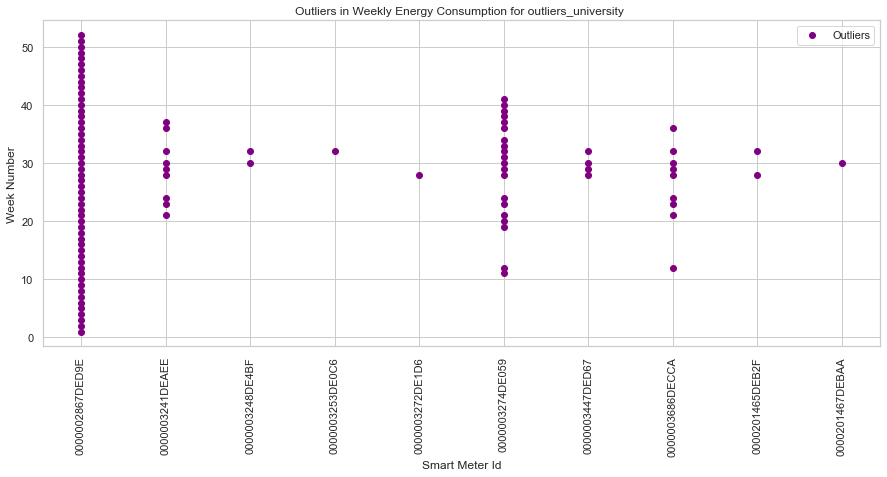

In [138]:
import matplotlib.pyplot as plt

# Plotting the outliers for Residential Colleges
plt.figure(figsize=(15, 6))

# Scatter plot with Smart Meter IDs on the x-axis and Week_Number on the y-axis
plt.scatter(outliers_university['Smart Meter Id'], outliers_university ['Week_Number'], 
            color='purple', label='Outliers')

plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel('Smart Meter Id')
plt.ylabel('Week Number')
plt.title('Outliers in Weekly Energy Consumption for outliers_university ')
plt.legend()
plt.grid(True)
plt.show()


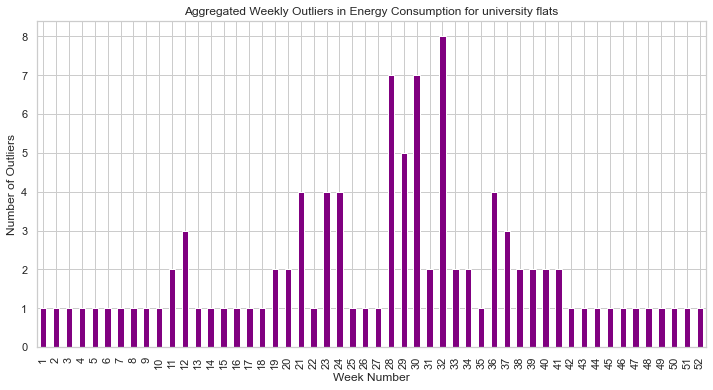

In [141]:
# Aggregating the number of outliers per week
weekly_outliers_count1 = outliers_university.groupby('Week_Number').size()

# Plotting the aggregated outliers per week
plt.figure(figsize=(12, 6))
weekly_outliers_count1.plot(kind='bar', color='purple')
plt.xlabel('Week Number')
plt.ylabel('Number of Outliers')
plt.title('Aggregated Weekly Outliers in Energy Consumption for university flats')
plt.grid(True)
plt.show()


In [180]:
# Count of how many times each Smart Meter ID has appeared as an outlier
outlier_counts = outliers_university ['Smart Meter Id'].value_counts()


# Displaying the Smart Meter IDs and their outlier counts
outlier_counts


Smart Meter Id
0000002867DED9E    52
0000003274DE059    20
0000003241DEAEE     9
0000003686DECCA     9
0000003447DED67     4
0000003248DE4BF     2
0000201465DEB2F     2
0000003253DE0C6     1
0000003272DE1D6     1
0000201467DEBAA     1
Name: count, dtype: int64

In [184]:
# Assuming outliers_residential is your DataFrame
# Step 1: Count the number of times each 'Smart Meter Id' appears as an outlier
outlier_counts = outliers_university['Smart Meter Id'].value_counts()

# Convert the Series to a DataFrame
outlier_counts_df = outlier_counts.reset_index()
outlier_counts_df.columns = ['Smart Meter Id', 'Outlier Count']

# Step 2: Merge this count with the outliers_residential DataFrame
merged_data = pd.merge(outlier_counts_df, outliers_university, on='Smart Meter Id')

# Step 3: Aggregate the total energy consumption for each 'Smart Meter Id'
final_data = merged_data.groupby(['Smart Meter Id', 'Address']).agg(
    Total_Energy_Consumption=('TotaldailyenergyConsumption', 'sum'),
    Outlier_Count=('Outlier Count', 'first')
).reset_index()




# Sort the DataFrame by 'Outlier_Count' in descending order
sorted_df = final_data.sort_values(by='Outlier_Count', ascending=False)
sorted_df.to_excel('sorted_data_universityflats.xlsx', index=False)
# The sorted data is now stored in sorted_df
print("outlier for university  flats")
sorted_df 

outlier for university  flats


<ipython-input-184-b1f2e4434fb0>:23: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  sorted_df.to_excel('sorted_data_universityflats.xlsx', index=False)


,Smart Meter Id,Address,Total_Energy_Consumption,Outlier_Count
0,0000002867DED9E,"G341 Uni Flats, 691 Cumberland Street North, D...",180844.70,52
5,0000003274DE059,"J423; Uni Flats, 850 Cumberland Street North, ...",23637.57,20
1,0000003241DEAEE,"J403 Uni Flats, 596 Castle Street North, Duned...",9494.66,9
7,0000003686DECCA,"Residence, 124 Dundas Street, Dunedin, Otago, ...",10134.20,9
6,0000003447DED67,"K307 - Uni Flats, 20 Howe Street, Dunedin, Ot...",4188.98,4
2,0000003248DE4BF,"J409 Uni Flats, Flat/614 Castle Street North, ...",2216.51,2
8,0000201465DEB2F,UNIT1 777 GREAT KING STREET NORTH DUNEDIN Otag...,2045.89,2
3,0000003253DE0C6,"J416 Uni Flats, Flat/624 Castle Street North, ...",1019.26,1
4,0000003272DE1D6,"J425 Uni Flats, Flat/858 Cumberland Street Nor...",1034.42,1
9,0000201467DEBAA,FLAT3 777 GREAT KING STREET NORTH DUNEDIN Otag...,1036.83,1


In [162]:
# Isolate the "University Flat" data
university_flats_data = energy_data[energy_data['Flats Category'] == 'University Flats']

# Display the first few rows of the university flats data to understand its structure
university_flats_data


,Smart Meter Id,Flats Category,Address,Street,Building Name,Building Code,Periods,Seasons,Date,TotaldailyenergyConsumption,...,3.00 PM,4.00 PM,5.00 PM,6.00 PM,7.00 PM,8.00 PM,9.00 PM,10.00 PM,11.00 PM,Week_Number
12572,0000002795DE203,University Flats,"G319 Uni Flats, 46 Saint David Street, Dunedin...",Saint David Street,Otago University Flat,G319,Holiday,summer,2022-01-01,51.68,...,1.95,1.78,1.88,2.02,2.13,2.55,2.19,2.12,2.26,52
12573,0000002795DE203,University Flats,"G319 Uni Flats, 46 Saint David Street, Dunedin...",Saint David Street,Otago University Flat,G319,Term Time,summer,2022-01-02,43.80,...,1.39,1.28,1.32,1.34,1.37,1.40,1.53,1.71,2.20,52
12574,0000002795DE203,University Flats,"G319 Uni Flats, 46 Saint David Street, Dunedin...",Saint David Street,Otago University Flat,G319,Term Time,summer,2022-01-03,40.93,...,1.35,1.37,1.40,1.98,1.51,1.64,1.75,1.71,1.74,1
12575,0000002795DE203,University Flats,"G319 Uni Flats, 46 Saint David Street, Dunedin...",Saint David Street,Otago University Flat,G319,Term Time,summer,2022-01-04,42.59,...,1.49,1.53,1.47,1.54,1.56,1.73,1.78,1.83,1.88,1
12576,0000002795DE203,University Flats,"G319 Uni Flats, 46 Saint David Street, Dunedin...",Saint David Street,Otago University Flat,G319,Holiday,summer,2022-01-05,46.02,...,1.93,1.93,1.94,2.04,2.12,2.51,1.99,2.09,2.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85754,0000208579DE738,University Flats,"J430 Uni Flats, Flatb2/878 Cumberland Street N...",Cumberland Street,Otago University Flat,J430,Term Time,Autumn,2023-03-21,45.60,...,2.45,1.78,1.62,1.74,2.22,4.37,3.57,4.90,1.43,12
85755,0000208579DE738,University Flats,"J430 Uni Flats, Flatb2/878 Cumberland Street N...",Cumberland Street,Otago University Flat,J430,Term Time,Autumn,2023-03-22,42.29,...,1.93,0.71,0.71,2.00,1.23,3.67,2.76,1.02,3.06,12
85756,0000208579DE738,University Flats,"J430 Uni Flats, Flatb2/878 Cumberland Street N...",Cumberland Street,Otago University Flat,J430,Term Time,Autumn,2023-03-23,49.15,...,0.98,0.70,1.77,1.60,3.22,5.09,4.75,2.32,2.15,12
85757,0000208579DE738,University Flats,"J430 Uni Flats, Flatb2/878 Cumberland Street N...",Cumberland Street,Otago University Flat,J430,Term Time,Autumn,2023-03-24,35.31,...,0.69,1.43,2.00,3.61,3.71,0.99,2.69,1.52,1.06,12


In [157]:
data=energy_data

In [158]:
# Separate the dataset into two categories: University Flats and Residential Colleges
uni_flats_data = data[data['Flats Category'] == 'University Flats']
res_colleges_data = data[data['Flats Category'] == 'Residential College']

# Function to calculate outlier thresholds using Standard Deviation and IQR methods
def calculate_thresholds(dataset):
    # Calculate mean and standard deviation
    mean = dataset['TotaldailyenergyConsumption'].mean()
    std_dev = dataset['TotaldailyenergyConsumption'].std()

    # Standard Deviation Method (3 standard deviations)
    std_dev_threshold_upper = mean + 3 * std_dev
    std_dev_threshold_lower = mean - 3 * std_dev

    # IQR Method
    Q1 = dataset['TotaldailyenergyConsumption'].quantile(0.25)
    Q3 = dataset['TotaldailyenergyConsumption'].quantile(0.75)
    IQR = Q3 - Q1
    iqr_threshold_upper = Q3 + 1.5 * IQR
    iqr_threshold_lower = Q1 - 1.5 * IQR

    return {
        "std_dev_upper": std_dev_threshold_upper,
        "std_dev_lower": std_dev_threshold_lower,
        "iqr_upper": iqr_threshold_upper,
        "iqr_lower": iqr_threshold_lower
    }

# Calculate thresholds for each category
uni_flats_thresholds = calculate_thresholds(uni_flats_data)
res_colleges_thresholds = calculate_thresholds(res_colleges_data)

uni_flats_thresholds, res_colleges_thresholds


({'std_dev_upper': 196.70406527392848,
  'std_dev_lower': -111.59016813247243,
  'iqr_upper': 136.65,
  'iqr_lower': -67.35},
 {'std_dev_upper': 231.93960110839316,
  'std_dev_lower': -132.82463934597604,
  'iqr_upper': 159.34500000000003,
  'iqr_lower': -83.095})

In [159]:
# Checking for the presence of "University Flat" data in the dataset
uni_flats_present = "University Flats" in data['Flats Category'].unique()

# Displaying whether "University Flat" data is present and the number of records if present
uni_flats_present, uni_flats_data.shape[0] if uni_flats_present else "No data"


(True, 48941)

In [160]:
# Identifying outliers in the "Residential College" category using both Standard Deviation and IQR methods
std_dev_upper_threshold = res_colleges_thresholds['std_dev_upper']
iqr_upper_threshold = res_colleges_thresholds['iqr_upper']

# Outliers based on Standard Deviation Method
std_dev_outliers = res_colleges_data[res_colleges_data['TotaldailyenergyConsumption'] > std_dev_upper_threshold]

# Outliers based on IQR Method
iqr_outliers = res_colleges_data[res_colleges_data['TotaldailyenergyConsumption'] > iqr_upper_threshold]

# Selecting relevant columns for the output
columns_to_display = ['Smart Meter Id', 'Address', 'TotaldailyenergyConsumption']

std_dev_outliers = std_dev_outliers[columns_to_display]
iqr_outliers = iqr_outliers[columns_to_display]

# Number of outliers detected by each method
num_std_dev_outliers = std_dev_outliers.shape[0]
num_iqr_outliers = iqr_outliers.shape[0]

num_std_dev_outliers, num_iqr_outliers, std_dev_outliers.head(), iqr_outliers.head()


(790,
 1952,
        Smart Meter Id                                            Address  \
 1487  0000002355DE9ED  Connection 1, 69 Heriot Row, Dunedin, Otago, 9016   
 1502  0000002355DE9ED  Connection 1, 69 Heriot Row, Dunedin, Otago, 9016   
 1508  0000002355DE9ED  Connection 1, 69 Heriot Row, Dunedin, Otago, 9016   
 1509  0000002355DE9ED  Connection 1, 69 Heriot Row, Dunedin, Otago, 9016   
 1510  0000002355DE9ED  Connection 1, 69 Heriot Row, Dunedin, Otago, 9016   
 
       TotaldailyenergyConsumption  
 1487                       245.46  
 1502                       232.14  
 1508                       245.34  
 1509                       232.86  
 1510                       241.94  ,
       Smart Meter Id                                            Address  \
 192  0000002341DE24A  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016   
 194  0000002341DE24A  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016   
 197  0000002341DE24A  Connection 1, 72 Heriot Row, Dunedin, Otago, 9016

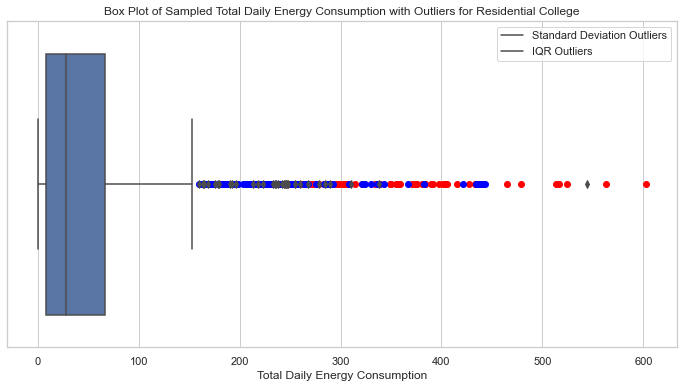

In [161]:
# Sampling a smaller subset of the data for visualization
sampled_data = res_colleges_data.sample(n=500, random_state=1)
sampled_std_dev_outliers = std_dev_outliers.sample(n=100, random_state=1)
sampled_iqr_outliers = iqr_outliers.sample(n=100, random_state=1)

# Creating a box plot with outliers highlighted for the sampled "Residential College" data
plt.figure(figsize=(12, 6))
sns.boxplot(x=sampled_data['TotaldailyenergyConsumption'])
plt.title('Box Plot of Sampled Total Daily Energy Consumption with Outliers for Residential College')
plt.xlabel('Total Daily Energy Consumption')

# Highlighting outliers based on Standard Deviation Method
plt.scatter(sampled_std_dev_outliers['TotaldailyenergyConsumption'], 
            [0]*len(sampled_std_dev_outliers), color='red')

# Highlighting outliers based on IQR Method
plt.scatter(sampled_iqr_outliers['TotaldailyenergyConsumption'], 
            [0]*len(sampled_iqr_outliers), color='blue')

# Adding legend
plt.legend(['Standard Deviation Outliers', 'IQR Outliers'])

# Show plot
plt.show()


In [117]:
# Identifying outliers in the "University flats" category using both Standard Deviation and IQR methods
std_dev_upper_threshold =uni_flats_thresholds['std_dev_upper']
iqr_upper_threshold =uni_flats_thresholds['iqr_upper']

# Outliers based on Standard Deviation Method
std_dev_outliers = uni_flats_data[uni_flats_data['TotaldailyenergyConsumption'] > std_dev_upper_threshold]

# Outliers based on IQR Method
iqr_outliers = uni_flats_data[uni_flats_data['TotaldailyenergyConsumption'] > iqr_upper_threshold]

# Selecting relevant columns for the output
columns_to_display = ['Smart Meter Id', 'Address', 'TotaldailyenergyConsumption']

std_dev_outliers = std_dev_outliers[columns_to_display]
iqr_outliers = iqr_outliers[columns_to_display]

# Number of outliers detected by each method
num_std_dev_outliers = std_dev_outliers.shape[0]
num_iqr_outliers = iqr_outliers.shape[0]

num_std_dev_outliers, num_iqr_outliers, std_dev_outliers.head(), iqr_outliers.head()

(404,
 1044,
         Smart Meter Id                                            Address  \
 17960  0000002867DED9E  G341 Uni Flats, 691 Cumberland Street North, D...   
 17964  0000002867DED9E  G341 Uni Flats, 691 Cumberland Street North, D...   
 17965  0000002867DED9E  G341 Uni Flats, 691 Cumberland Street North, D...   
 17966  0000002867DED9E  G341 Uni Flats, 691 Cumberland Street North, D...   
 17967  0000002867DED9E  G341 Uni Flats, 691 Cumberland Street North, D...   
 
        TotaldailyenergyConsumption  
 17960                        215.9  
 17964                        212.3  
 17965                        254.6  
 17966                        239.0  
 17967                        222.1  ,
         Smart Meter Id                                            Address  \
 15863  0000002811DE94C  Cumberland Court H - G306, 483 Great King Stre...   
 17267  0000002858DE5B8  Cumberland Court B - G348, 60 Union Street Wes...   
 17273  0000002858DE5B8  Cumberland Court B - G348, 60

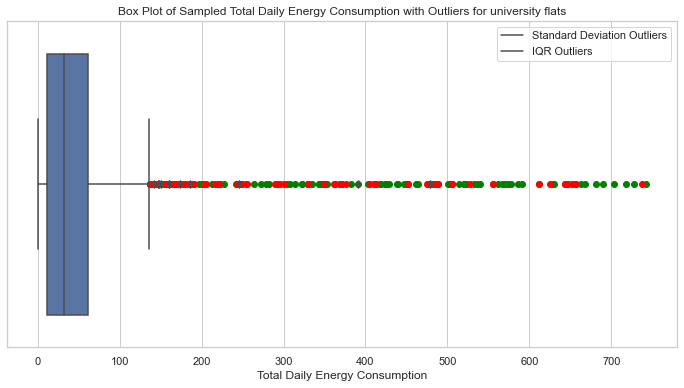

In [118]:
# Sampling a smaller subset of the data for visualization
sampled_data = uni_flats_data.sample(n=500, random_state=1)
sampled_std_dev_outliers = std_dev_outliers.sample(n=100, random_state=1)
sampled_iqr_outliers = iqr_outliers.sample(n=100, random_state=1)

# Creating a box plot with outliers highlighted for the sampled "Residential College" data
plt.figure(figsize=(12, 6))
sns.boxplot(x=sampled_data['TotaldailyenergyConsumption'])
plt.title('Box Plot of Sampled Total Daily Energy Consumption with Outliers for university flats')
plt.xlabel('Total Daily Energy Consumption')

# Highlighting outliers based on Standard Deviation Method
plt.scatter(sampled_std_dev_outliers['TotaldailyenergyConsumption'], 
            [0]*len(sampled_std_dev_outliers), color='green')

# Highlighting outliers based on IQR Method
plt.scatter(sampled_iqr_outliers['TotaldailyenergyConsumption'], 
            [0]*len(sampled_iqr_outliers), color='red')

# Adding legend
plt.legend(['Standard Deviation Outliers', 'IQR Outliers'])

# Show plot
plt.show()
